In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram

import numpy as np

In [2]:
from qiskit import execute, Aer

simulator = Aer.get_backend('qasm_simulator')

In [147]:
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Tool Functions

In [5]:
from qiskit.quantum_info import DensityMatrix, Statevector, Operator

def getDensityMatrix(circuit):
    return DensityMatrix(circuit).data

### - dagger and tensor 

In [6]:
state_0 = np.array([1, 0])
state_1 = np.array([0, 1])

In [7]:
from functools import reduce

Dag = lambda matrix: matrix.conj().T
Kron = lambda *matrices: reduce(np.kron, matrices)

### - pretty print

In [8]:
def pm(matrix):
    for row in range(len(matrix)):
        for col in range (len(matrix[row])):
            print("{:.3f}".format(matrix[row][col]), end = " ")
        print()

### - measurements

In [9]:
def getMeasurements(n):
    psi_0 = np.array([1.0, 0.0])
    psi_1 = np.array([0.0, 1.0])
    I = np.eye(2)

    M_0 = psi_0.reshape([2, 1]) @ psi_0.reshape([1, 2]).conj()
    M_1 = psi_1.reshape([2, 1]) @ psi_1.reshape([1, 2]).conj()
    
    M = [M_0, M_1]
    
    measurements = []
    for i in range(2 ** n):
        binnum = bin(i)[2:].rjust(n, '0')

        temp = []
        indices = map(lambda x: int(x), list(binnum))
        for index in indices:
            temp.append(M[index])
        
        measurements.append( Kron(*temp) )
    
    return measurements

In [10]:
def measure(M, state):
    return Dag(state) @ Dag(M) @ M @ state

# 1. Find <3> in 2-qubits database

In [11]:
# https://qiskit.org/textbook/ch-algorithms/grover.html

## 1.1 set up starting state

In [1]:
def initCircuit(n):
    circuit = QuantumCircuit(n, n)
    
    for i in range(n):
        circuit.h(i)
    circuit.barrier()
    
    return circuit

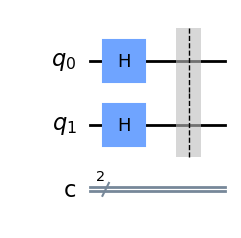

In [13]:
inputCircuit_2q = initCircuit(2)
inputCircuit_2q.draw(output='mpl')

## 1.2 creating Oracle for n=3

In [14]:
def createOracle_3():
    circuit = QuantumCircuit(2, 2)

    # Oracle for find 3

    # U_f 
    circuit.cz(0, 1)
    circuit.barrier()
    
    return circuit

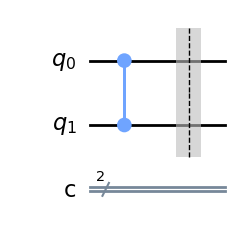

In [15]:
oracleCircuit_3 = createOracle_3()
oracleCircuit_3.draw(output='mpl')

### - test Oralce

In [16]:
O_3 = Operator(oracleCircuit_3).data
pm(O_3)

1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 1.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j -1.000+0.000j 


In [17]:
# all possible states
state_00 = Kron(state_0, state_0)
state_01 = Kron(state_0, state_1)
state_10 = Kron(state_1, state_0)
state_11 = Kron(state_1, state_1)

In [18]:
print("O|00>", O_3 @ state_00)
print("O|01>", O_3 @ state_01)
print("O|10>", O_3 @ state_10)
print("O|11>", O_3 @ state_11) # flip phase

O|00> [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
O|01> [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
O|10> [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
O|11> [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]


## 1.3 Diffuser

In [19]:
# H R H, where R = 2|0><0| - I 

### 1.3.1 R = 2|0><0| - I  (Conditional phase shift gate)

In [20]:
def createR_2q():
    circuit = QuantumCircuit(2, 2)
    
    circuit.z(0)
    circuit.z(1)
    circuit.cz(0, 1)
    
    return circuit

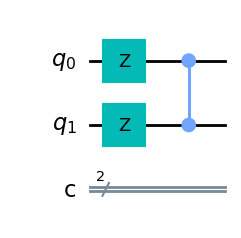

In [21]:
R_2q = createR_2q()
R_2q.draw(output='mpl')

### - test R

In [22]:
R_2q = Operator(R_2q).data
pm(R_2q)

1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j -1.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j -1.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j -1.000+0.000j 


In [23]:
# flip phase(no work on zero states) => Conditional Phase Shift gate
print("RO|00>", R_2q @ O_3 @ state_00) # zero state => would not flip
print("RO|01>", R_2q @ O_3 @ state_01)
print("RO|10>", R_2q @ O_3 @ state_10)
print("RO|11>", R_2q @ O_3 @ state_11)

RO|00> [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
RO|01> [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
RO|10> [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
RO|11> [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


### 1.3.2 diffuser circuit

In [24]:
def createDiffuser_2q():
    circuit = QuantumCircuit(2, 2)
    
    circuit.h(0)
    circuit.h(1)
    circuit = circuit.compose(createR_2q())
    circuit.h(0)
    circuit.h(1)
    circuit.barrier()
    
    return circuit

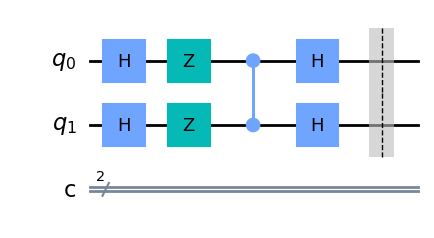

In [25]:
diffuserCircuit_2q = createDiffuser_2q()
diffuserCircuit_2q.draw(output='mpl')

### - test diffuser

In [26]:
diff_2q = Operator(diffuserCircuit_2q).data
pm(diff_2q)

-0.500+0.000j 0.500+0.000j 0.500+0.000j 0.500+0.000j 
0.500+0.000j -0.500+0.000j 0.500+0.000j 0.500+0.000j 
0.500+0.000j 0.500+0.000j -0.500+0.000j 0.500+0.000j 
0.500+0.000j 0.500+0.000j 0.500+0.000j -0.500+0.000j 


In [27]:
DB = 0.5 * state_00 + 0.5 * state_01 + 0.5 * state_10 + 0.5 * state_11
print("DO|DB>", diff_2q @ O_3 @ DB)

DO|DB> [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


## 1.4 Grover iteration

In [28]:
def createGroverIteration(oracle, diffuser):
    return oracle.compose(diffuser)

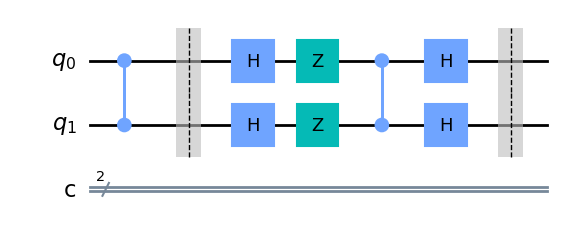

In [29]:
groverIteration_2q = createGroverIteration(createOracle_3(), createDiffuser_2q())
groverIteration_2q.draw(output='mpl')

## 1.5 Measure

In [30]:
groverIteration_2q = createGroverIteration(createOracle_3(), createDiffuser_2q())

### 1.5.1 one grover iteration

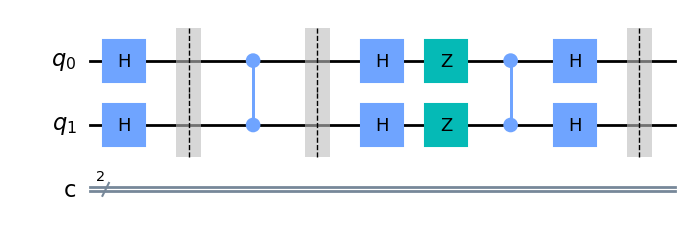

In [31]:
grover_2q_1 = initCircuit(2).compose(groverIteration_2q.copy())
grover_2q_1.draw(output='mpl')

In [32]:
grover_2q_1.measure([0, 1], [0, 1])

In [33]:
job = execute(grover_2q_1, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_2q_1)
print(counts)

{'11': 10000}


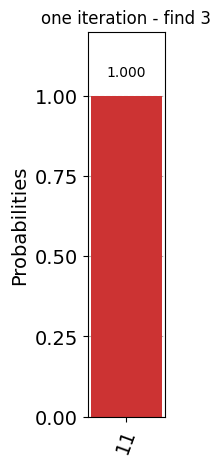

In [34]:
plot_histogram(counts, figsize=(1, 5), color="#CC3333", title="one iteration - find 3")

### 1.5.2 two grover iteration

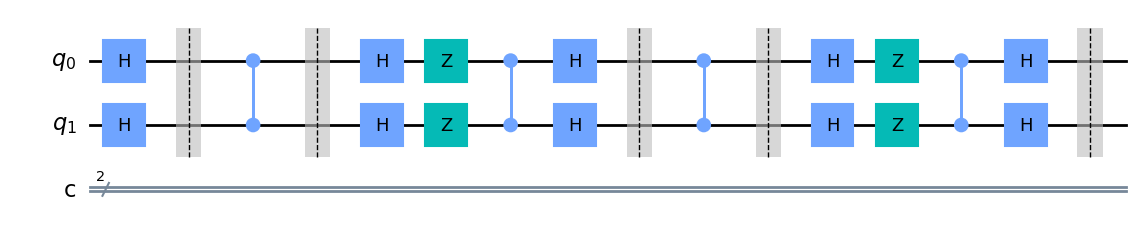

In [35]:
grover_2q_2 = initCircuit(2).compose(groverIteration_2q.copy()).compose(groverIteration_2q.copy())
grover_2q_2.draw(output='mpl')

In [36]:
grover_2q_2.measure([0, 1], [0, 1])

In [37]:
job = execute(grover_2q_2, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_2q_2)
print(counts)

{'11': 2564, '00': 2517, '10': 2480, '01': 2439}


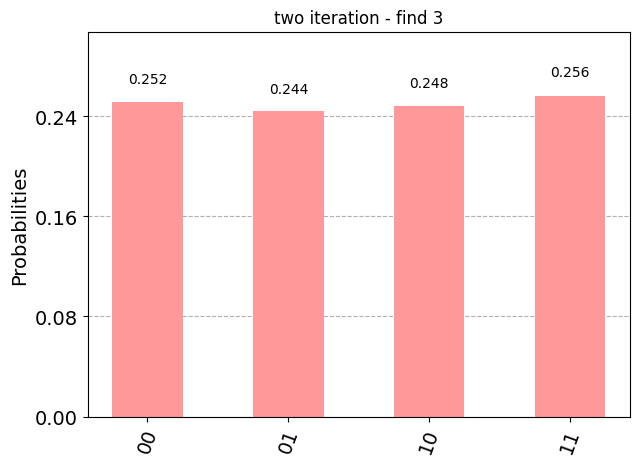

In [38]:
plot_histogram(counts, figsize=(7, 5), color="#FF9999", title="two iteration - find 3")

# 2. Find <6> in 3-qubits database

In [39]:
# https://www.quantum-inspire.com/kbase/grover-algorithm/

## 2.1 set up starting state

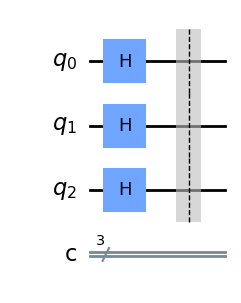

In [40]:
inputCircuit_3q = initCircuit(3)
inputCircuit_3q.draw(output='mpl')

## 2.2 Creating oracle for 6

In [41]:
def createOracle_6():
    circuit = QuantumCircuit(3, 3)

    # Oracle for find 6

    # U_f 
    circuit.x(0)
    circuit.h(2)
    circuit.ccx(0, 1, 2)
    circuit.h(2)
    circuit.x(0)
    
    circuit.barrier()
    
    return circuit

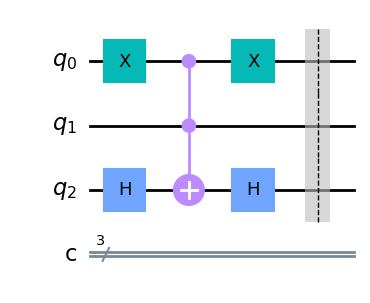

In [42]:
oracleCircuit_6 = createOracle_6()
oracleCircuit_6.draw(output='mpl')

### - test oracle

In [43]:
# where the entry that correspond to the marked item will have a negative phase
pm(Operator(oracleCircuit_6).data)

1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j -1.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 1.000+0.000j 


In [44]:
Operator(oracleCircuit_6).data

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         1.+0.j]])

## 2.3 Diffuser

In [45]:
# H R H, where R = 2|0><0| - I 

### 2.3.1 R = 2|0><0| - I 

In [46]:
def createR_3q():
    circuit = QuantumCircuit(3, 3)
    
    circuit.x(2)
    circuit.x(0)
    circuit.x(1)
    circuit.h(2)
    circuit.ccx(0, 1, 2)
    circuit.barrier(0)
    circuit.barrier(1)
    circuit.h(2)
    circuit.x(2)
    circuit.x(0)
    circuit.x(1)
    
    return circuit

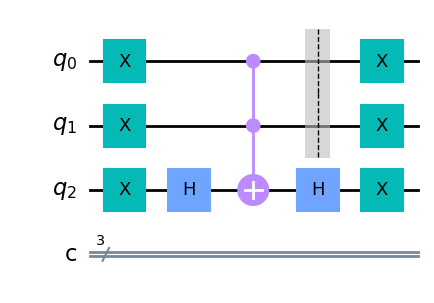

In [47]:
R_3q = createR_3q()
R_3q.draw(output='mpl')

### - test R

In [48]:
pm(Operator(R_3q).data)

-1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 1.000+0.000j 0.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 1.000+0.000j 0.000+0.000j 
0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 0.000+0.000j 1.000+0.000j 


In [49]:
print('|000>', Kron(state_0, state_0, state_0))
print('R|000>',Operator(R_3q).data @ Kron(state_0, state_0, state_0) )

print('|010>', Kron(state_0, state_1, state_0))
print('R|010>',Operator(R_3q).data @ Kron(state_0, state_1, state_0) )

print('|110>', Kron(state_1, state_1, state_0))
print('R|110>',Operator(R_3q).data @ Kron(state_1, state_1, state_0) )

|000> [1 0 0 0 0 0 0 0]
R|000> [-1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
|010> [0 0 1 0 0 0 0 0]
R|010> [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
|110> [0 0 0 0 0 0 1 0]
R|110> [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]


### 2.3.2 diffuser

In [50]:
def createDiffuser_3q():
    circuit = QuantumCircuit(3, 3)
    
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit = circuit.compose(createR_3q())
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.barrier()
    
    return circuit

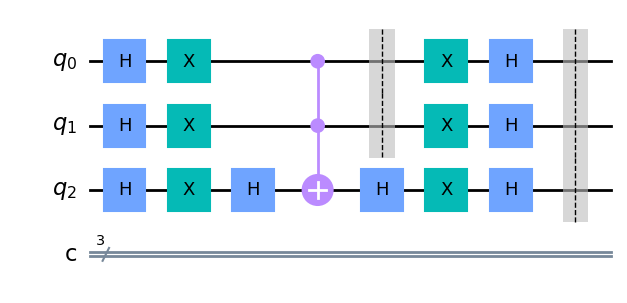

In [51]:
diffuserCircuit_3q = createDiffuser_3q()
diffuserCircuit_3q.draw(output='mpl')

### - test Diffuser

In [52]:
pm(Operator(diffuserCircuit_3q).data)

0.750+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j 
-0.250+0.000j 0.750+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j 
-0.250+0.000j -0.250+0.000j 0.750+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j 
-0.250+0.000j -0.250+0.000j -0.250+0.000j 0.750+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j 
-0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j 0.750+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j 
-0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j 0.750+0.000j -0.250+0.000j -0.250+0.000j 
-0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j 0.750+0.000j -0.250+0.000j 
-0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j -0.250+0.000j 0.750+0.000j 


## 2.4 Grover iteration

In [53]:
groverIteration_3q = createGroverIteration(createOracle_6(), createDiffuser_3q())

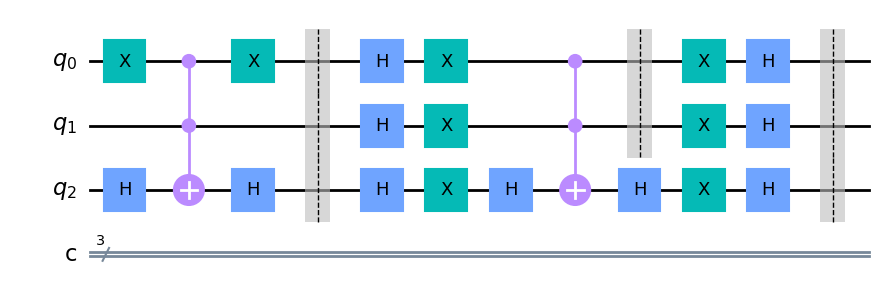

In [54]:
groverIteration_3q.draw(output='mpl')

## 2.5 Measure

### 2.5.0 input Circuit

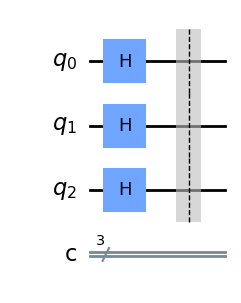

In [55]:
inputCircuit_3q = initCircuit(3)
inputCircuit_3q.draw(output='mpl')

In [56]:
inputCircuit_3q.measure([0, 1, 2], [0, 1, 2])

In [60]:
job = execute(inputCircuit_3q, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(inputCircuit_3q)
print(counts)

{'001': 1239, '100': 1250, '110': 1247, '010': 1236, '011': 1274, '000': 1259, '111': 1223, '101': 1272}


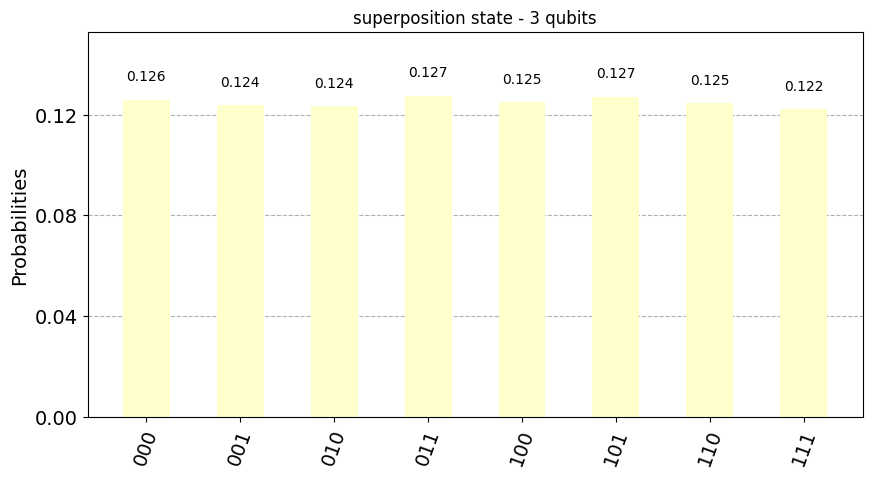

In [61]:
plot_histogram(counts, figsize=(10, 5), color="#FFFFCC", title="superposition state - 3 qubits")

### 2.5.1 one grover iteration

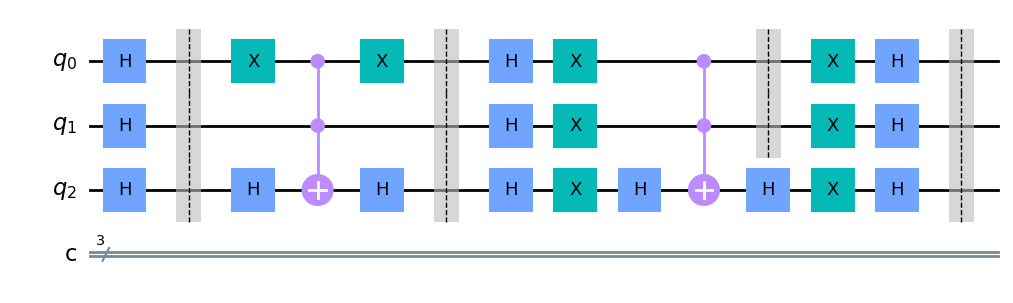

In [62]:
grover_3q_1 = initCircuit(3).compose(groverIteration_3q.copy())
grover_3q_1.draw(output='mpl')

In [63]:
grover_3q_1.measure([0, 1, 2], [0, 1, 2])

In [64]:
job = execute(grover_3q_1, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_3q_1)
print(counts)

{'110': 7782, '000': 313, '011': 335, '101': 328, '111': 285, '001': 352, '010': 297, '100': 308}


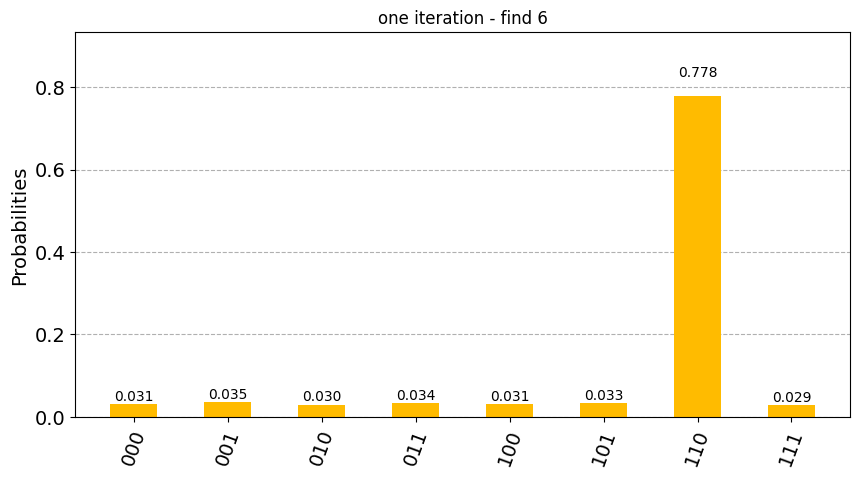

In [65]:
plot_histogram(counts, figsize=(10, 5), color="#FFBB00", title="one iteration - find 6")

### 2.5.2 two grover iteration

In [66]:
grover_3q_2 = initCircuit(3).compose(groverIteration_3q.copy()).compose(groverIteration_3q.copy())
# grover_3q_2.draw(output='mpl')

In [67]:
grover_3q_2.measure([0, 1, 2], [0, 1, 2])

In [68]:
job = execute(grover_3q_2, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_3q_2)
print(counts)

{'110': 9473, '111': 67, '001': 80, '000': 69, '101': 80, '010': 70, '100': 85, '011': 76}


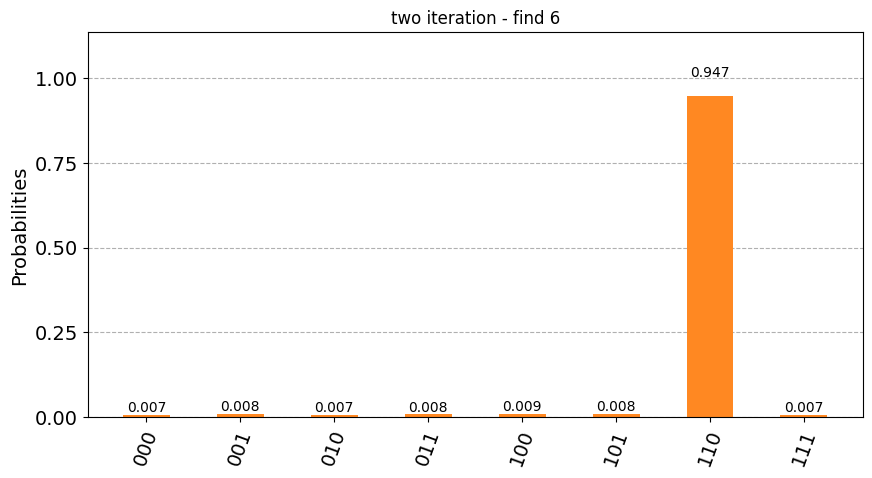

In [69]:
plot_histogram(counts, figsize=(10, 5), color="#FF8822", title="two iteration - find 6")

### 2.5.3 three grover iteration

In [70]:
grover_3q_3 = initCircuit(3).compose(groverIteration_3q.copy()).compose(groverIteration_3q.copy()).compose(groverIteration_3q.copy())
# grover_3q_3.draw(output='mpl')

In [71]:
grover_3q_3.measure([0, 1, 2], [0, 1, 2])

In [72]:
job = execute(grover_3q_3, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_3q_3)
print(counts)

{'101': 912, '110': 3397, '010': 953, '011': 918, '100': 912, '001': 956, '111': 979, '000': 973}


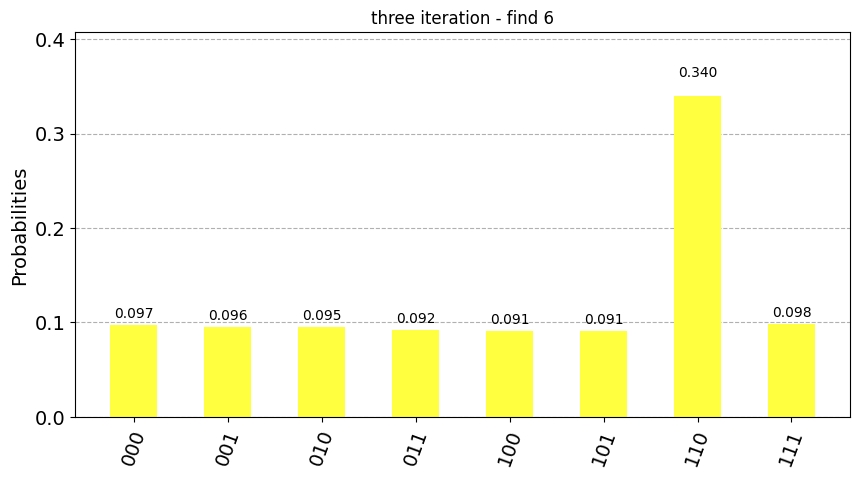

In [73]:
plot_histogram(counts, figsize=(10, 5), color="#FFFF3F", title="three iteration - find 6")

### - theoretical calculation

In [75]:
import math

In [76]:
theta = math.degrees( math.asin(1 / math.sqrt(8)) )
theta

20.704811054635428

In [77]:
k_tilde = 180 / (4 * theta) - 0.5
k_tilde

1.6734079041462842

In [78]:
for k in range(1, 4):
    print(f'k = {k}: { math.sin(math.radians( (2 * k+1) * theta) ) ** 2 }')

k = 1: 0.7812499999999999
k = 2: 0.9453125000000001
k = 3: 0.33007812500000033


## 3. Amplitude amplification

In [79]:
# H R H, where R = 2|0><0| - I 
# A R A^(-1)

## 3.1 set up starting state

In [80]:
def initAACircuit(n):
    circuit = QuantumCircuit(n, n)
    
    circuit.x(0)
    circuit.h(1)
    circuit.z(1)
    circuit.h(0)
    circuit.barrier()
    
    return circuit

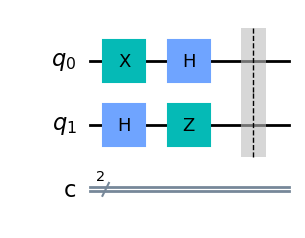

In [81]:
inputAACircuit = initAACircuit(2)
inputAACircuit.draw(output='mpl')

In [82]:
A = Operator(initAACircuit(2))

In [83]:
np.allclose(A.data @ Dag(A.data), np.eye(4))

True

### - test A

In [84]:
inputAACircuit.measure([0, 1], [0, 1])

In [85]:
job = execute(inputAACircuit, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(inputAACircuit)
print(counts)

{'01': 2567, '00': 2491, '10': 2474, '11': 2468}


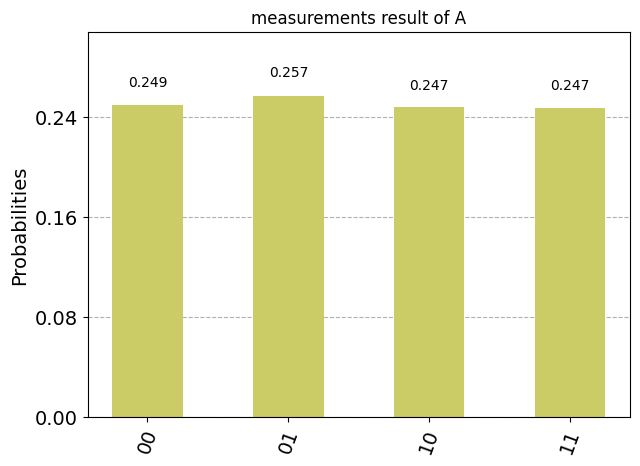

In [86]:
plot_histogram(counts, figsize=(7, 5), color="#CCCC66", title="measurements result of A")

## 3.2 Creating Oracle for finding 3

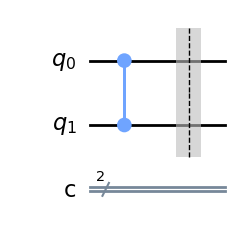

In [87]:
oracleCircuit_3 = createOracle_3()
oracleCircuit_3.draw(output='mpl')

## 3.3 Correct Diffuser

In [88]:
def createAADiffuser():
    circuit = QuantumCircuit(2, 2)
    
    circuit.append(A, [0, 1])
    circuit = circuit.compose(createR_2q())
    circuit.append(A.conjugate(), [0, 1])
    circuit.barrier()
    
    return circuit

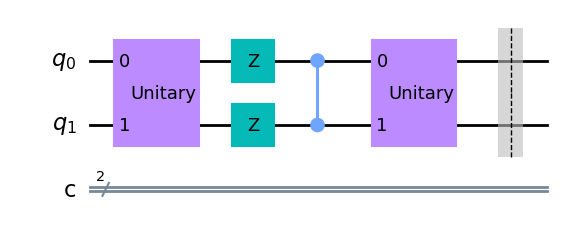

In [89]:
diffuserAACircuit = createAADiffuser()
diffuserAACircuit.draw(output='mpl')

## 3.4 Grover iteration

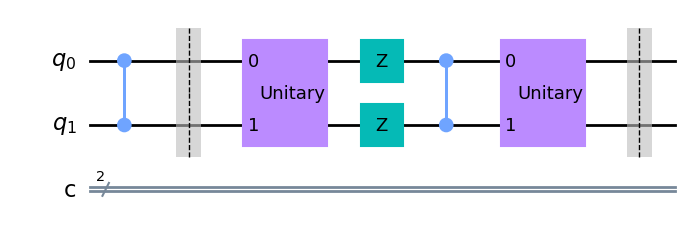

In [90]:
aaGroverIteration = createGroverIteration(createOracle_3(), createAADiffuser())
aaGroverIteration.draw(output='mpl')

## 3.5 Measure

### 3.5.1 incorrect diffuser

In [92]:
incorrectGroverIteration = createGroverIteration(createOracle_3(), createDiffuser_2q())

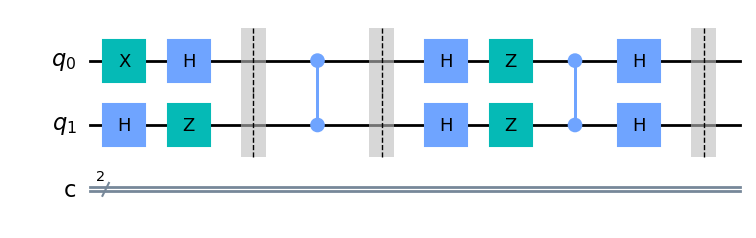

In [93]:
grover_incorrect_diffuser = initAACircuit(2).compose(incorrectGroverIteration)
grover_incorrect_diffuser.draw(output='mpl')

In [94]:
grover_incorrect_diffuser.measure([0, 1], [0, 1])

In [95]:
job = execute(grover_incorrect_diffuser, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_incorrect_diffuser)
print(counts)

{'00': 10000}


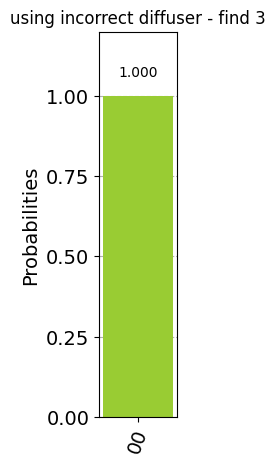

In [96]:
plot_histogram(counts, figsize=(1, 5), color="#99CC33", title="using incorrect diffuser - find 3")

### 3.5.2 correct diffuser

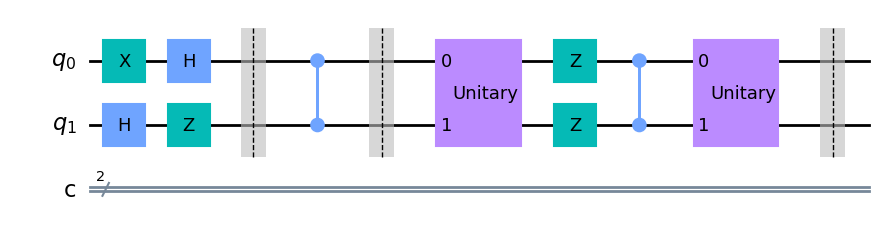

In [97]:
grover_correct_diffuser = initAACircuit(2).compose(aaGroverIteration)
grover_correct_diffuser.draw(output='mpl')

In [98]:
grover_correct_diffuser.measure([0, 1], [0, 1])

In [99]:
job = execute(grover_correct_diffuser, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_correct_diffuser)
print(counts)

{'11': 10000}


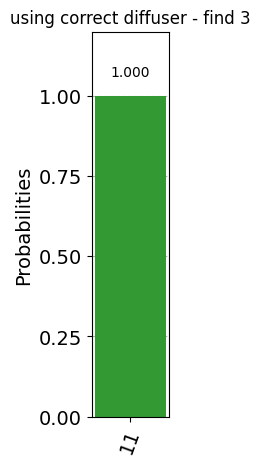

In [100]:
plot_histogram(counts, figsize=(1, 5), color="#339933", title="using correct diffuser - find 3")

## 4. Case when t/N = 1/2

### 4.1 set up starting state

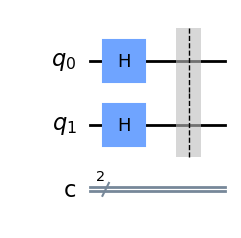

In [101]:
inputCircuit_2q = initCircuit(2)
inputCircuit_2q.draw(output='mpl')

### 4.2 Creating oracle for even

In [102]:
def createEvenOracle():
    circuit = QuantumCircuit(2, 2)
    
    circuit.x(0)
    circuit.x(1)
    circuit.cz(0, 1)
    circuit.x(1)
    circuit.cz(0, 1)
    circuit.x(0)
    circuit.barrier()
    
    return circuit

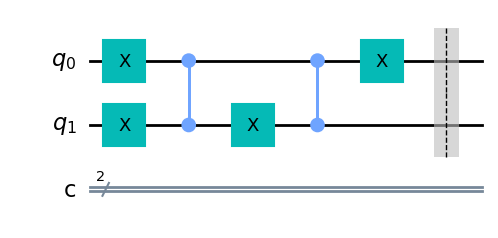

In [103]:
evenOracle = createEvenOracle()
evenOracle.draw(output='mpl')

### - test Oracle

In [104]:
Operator(evenOracle).data # find 0 and 2

array([[-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

### 4.3 Diffuser

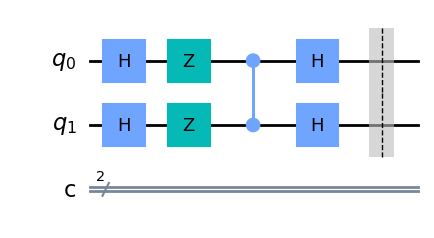

In [105]:
diffuserCircuit_2q = createDiffuser_2q()
diffuserCircuit_2q.draw(output='mpl')

### 4.4 Measurements

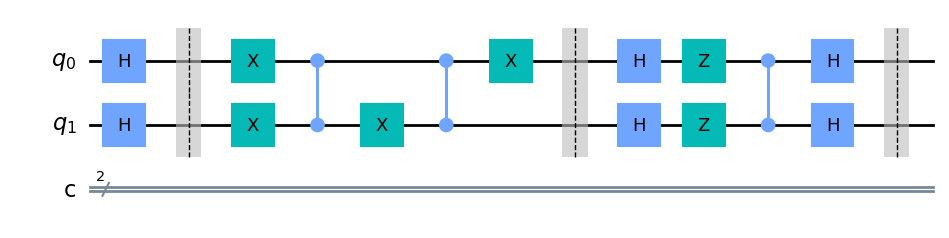

In [106]:
grover_even = initCircuit(2).compose(createEvenOracle()).compose(createDiffuser_2q())
grover_even.draw(output='mpl')

In [107]:
grover_even.measure([0, 1], [0, 1])

In [108]:
job = execute(grover_even, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_even)
print(counts)

{'10': 2447, '01': 2561, '00': 2447, '11': 2545}


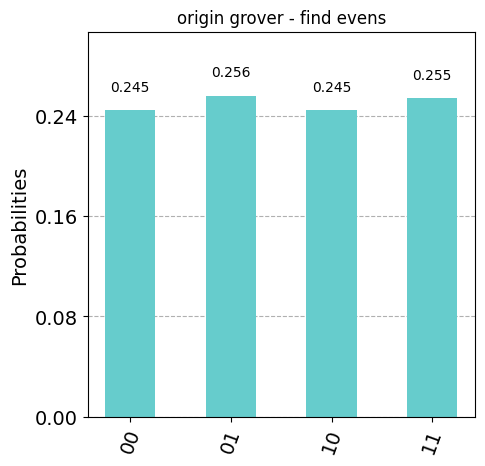

In [109]:
plot_histogram(counts, figsize=(5, 5), color="#66CCCC", title="origin grover - find evens")

## 5. differnent phase rotation Grover

### 5.1 Initial State

In [315]:
initState = Kron(
    state_0, state_0, state_0, state_0, state_0, 
    state_0, state_0, state_0, state_0, state_0
)

In [317]:
H = np.array([[1,1], [1,-1]]) / (np.sqrt(2))
H_9 = Kron(H, H, H, H, H, H, H, H, H)
H_10 = Kron(H, H, H, H, H, H, H, H, H, H)

### - target states

In [319]:
def createTargetState(n):
    states = []
    s = bin(n)[2:].rjust(10, "0")
    for i in list(s):
        if i == '0':
            states.append(state_0)
        else:
            states.append(state_1)
    return Kron(*states)

def createTargetStates(p):
    n = math.floor(p * 1024)
    
    state = createTargetState(0)
    for i in range(1, n):
        state = state + createTargetState(i)
        
    return state / (np.sqrt(n))

In [114]:
target_states = [
    [createTargetStates(0.05), 0.05], # 0.05
    [createTargetStates(0.1), 0.1], # 0.1
    [createTargetStates(0.15), 0.15], # 0.15
    [createTargetStates(0.2), 0.2], # 0.2
    [createTargetStates(0.25), 0.25], # 0.25
    [createTargetStates(0.3), 0.3], # 0.3
    [createTargetStates(0.35), 0.35], # 0.35
    [createTargetStates(0.4), 0.4], # 0.4
    [createTargetStates(0.45), 0.45], # 0.45
    [createTargetStates(0.5), 0.5], # 0.5
    [createTargetStates(0.55), 0.55], # 0.55
    [createTargetStates(0.6), 0.6], # 0.6
    [createTargetStates(0.65), 0.65], # 0.65
    [createTargetStates(0.7), 0.7], # 0.7
    [createTargetStates(0.75), 0.75], # 0.75
    [createTargetStates(0.8), 0.8], # 0.8
    [createTargetStates(0.85), 0.85], # 0.85
    [createTargetStates(0.9), 0.9], # 0.9
    [createTargetStates(0.95), 0.95], # 0.95
    [createTargetStates(1), 1] # 1
]

### 5.2 Create Oracles

### - 5.2.0 create original Oracle and diffuser

In [115]:
def createOriginalOracle(target_state):
    N = 1024
    O = np.eye(N) - 2 * ( Dag(target_state).reshape(N, 1) @ target_state.reshape(1, N) )
    
    return O

def createOriginalDiffuser():
    N = 1024

    R = 2 * ( 
        Dag(initState).reshape(N, 1) @ 
        initState.reshape(1, N) 
    ) - np.eye(N)
    
    return  H_10 @ R @ Dag(H_10)

### - 5.2.1 create Oracle and diffuser with pi/2

In [116]:
def createHalfPIOracle(target_state):
    N = 1024
    alpha = np.pi / 2
    alpha_phase = np.exp(alpha * 1j)

    # Oracle = I - (1 - e^(αi))|target><target|

    O = np.eye(N) - (1 - alpha_phase) * \
        ( Dag(target_state).reshape(N, 1) @ target_state.reshape(1, N) )
    
    return O

def createHalfPIDiffuser():
    N = 1024
    beta = -np.pi / 2
    beta_phase = np.exp(beta * 1j)

    # R = (1 - e^(βi))|0><0| + e^(βi)I
    R = (1 - beta_phase) * ( 
        Dag(initState).reshape(N, 1) @ 
        initState.reshape(1, N) 
    ) + beta_phase * np.eye(N)
    
    return  H_10 @ R @ Dag(H_10)

### - 5.2.2 create Oracle and diffuer with 0.1pi

In [130]:
def createOneTenthPIOracle(target_state):
    N = 1024
    alpha = np.pi / 10
    alpha_phase = np.exp(alpha * 1j)

    # Oracle = I - (1 - e^(αi))|target><target|

    O = np.eye(N) - (1 - alpha_phase) * \
        ( Dag(target_state).reshape(N, 1) @ target_state.reshape(1, N) )
    
    return O

def createOneTenthPIDiffuser():
    N = 1024
    beta = -np.pi / 10
    beta_phase = np.exp(beta * 1j)

    # R = (1 - e^(βi))|0><0| + e^(βi)I
    R = (1 - beta_phase) * ( 
        Dag(initState).reshape(N, 1) @ 
        initState.reshape(1, N) 
    ) + beta_phase * np.eye(N)
    
    return  H_10 @ R @ Dag(H_10)

### - 5.2.3 create Youne Oracle and diffuer

In [391]:
def createYouneOracle(n):
    O = np.eye(1024)
    for i in range(n):
        O[i][i] = 0
        O[i][i + 512] = 1
        O[i + 512][i + 512] = 0
        O[i + 512][i] = 1
    
    return O

def createYouneDiffuser():
    N = 512

    R = (2 * Dag(initState).reshape(N * 2, 1) @ 
        initState.reshape(1, N * 2) - np.eye(N * 2))
    
    return  Kron(np.eye(2), H_9) @ R @ Dag(Kron(np.eye(2), H_9))

### 5.3 measurements

In [118]:
measurements = getMeasurements(10)

### - 5.3.0 measurements using original implementaion

In [119]:
# test: one grover iteration
x_o = []
y_o = []
for target_state, p in target_states:
    n = math.floor(p * 1024)

    O = createOriginalOracle(target_state)
    diff = createOriginalDiffuser()
    final_state = diff @ O @ H_10 @ initState

    probability = 0.0
    for i in range(1024):
        if i < n:
            probability = probability + measure(measurements[i], final_state)
    
#     print(f'p={p}, probability={probability}')
    x_o.append(p)
    y_o.append(probability)

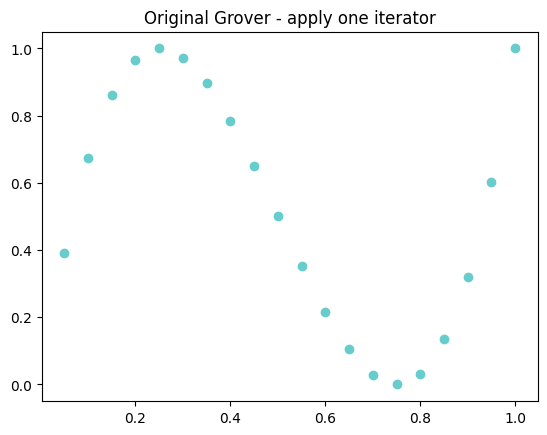

In [120]:
plt.title("Original Grover - apply one iterator")
plt.scatter(x_o, y_o, color="#66CCCC")

In [124]:
# test: best probability
x_o_best = []
y_o_best = []
for target_state, p in target_states:
    n = math.floor(p * 1024)

    O = createOriginalOracle(target_state)
    diff = createOriginalDiffuser()
    final_state = H_10 @ initState

    theta = math.degrees( math.asin(math.sqrt(p)) )
    k_tilde = math.floor( 180 / (4 * theta) - 0.5 )
    for i in range(k_tilde):
        final_state = diff @ O @ final_state

    probability = 0.0
    for i in range(1024):
        if i < n:
            probability = probability + measure(measurements[i], final_state)
    
    final_state = diff @ O @ final_state
    probability2 = 0.0
    for i in range(1024):
        if i < n:
            probability2 = probability2 + measure(measurements[i], final_state)
            
#     print(f'p={p}, probability={probability}')
    x_o_best.append(p)
    y_o_best.append(max(probability, probability2))

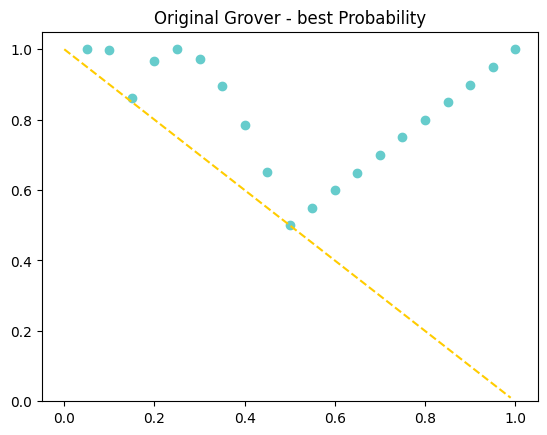

In [237]:
plt.title("Original Grover - best Probability")
x = np.arange(-0,1,0.01)
y = 1 - x
plt.plot(x, y, ls='--', color="#FFCC00")

plt.ylim(0, 1.05)
plt.scatter(x_o_best, y_o_best, color="#66CCCC")

### - 5.3.1 measurements using pi/2

In [126]:
# test: one grover iteration
x_half_pi = []
y_half_pi= []
for target_state, p in target_states:
    n = math.floor(p * 1024)

    O = createHalfPIOracle(target_state)
    diff = createHalfPIDiffuser()
    final_state = diff @ O @ H_10 @ initState

    probability = 0.0
    for i in range(1024):
        if i < n:
            probability = probability + measure(measurements[i], final_state)
    
#     print(f'p={p}, probability={probability}')
    x_half_pi.append(p)
    y_half_pi.append(probability)

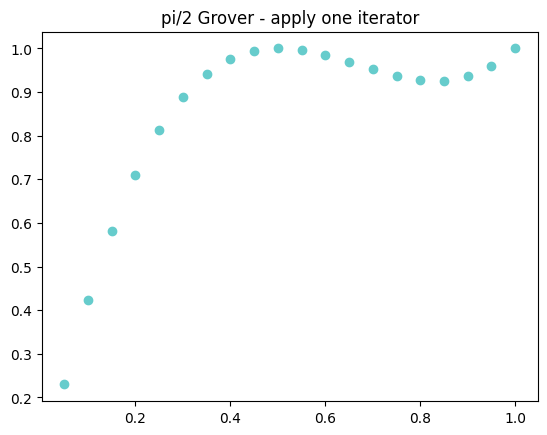

In [245]:
plt.title("pi/2 Grover - apply one iterator")
plt.scatter(x_half_pi, y_half_pi, color="#66CCCC")

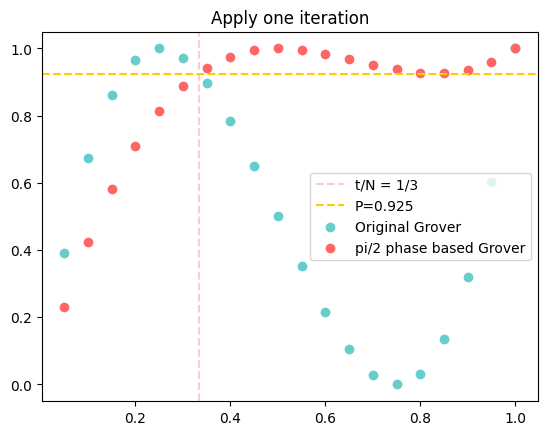

In [314]:
# one grover iteration - pi/2 vs origin

fig, ax = plt.subplots()
plt.title("Apply one iteration")
plt.axvline(1/3, linestyle='--', color="#FFCCCC", label="t/N = 1/3")
plt.axhline(0.925, linestyle='--', color="#FFCC00", label="P=0.925")
plt.scatter(x_o, y_o, color="#66CCCC", label="Original Grover")
plt.scatter(x_half_pi, y_half_pi, color="#FF6666", label="pi/2 phase based Grover")
ax.legend()

### - 5.3.2 measurements using 0.1pi

In [131]:
# test: one grover iteration
x_ot_pi = []
y_ot_pi= []
for target_state, p in target_states:
    n = math.floor(p * 1024)

    O = createOneTenthPIOracle(target_state)
    diff = createOneTenthPIDiffuser()
    final_state = diff @ O @ H_10 @ initState

    probability = 0.0
    for i in range(1024):
        if i < n:
            probability = probability + measure(measurements[i], final_state)
    
#     print(f'p={p}, probability={probability}')
    x_ot_pi.append(p)
    y_ot_pi.append(probability)

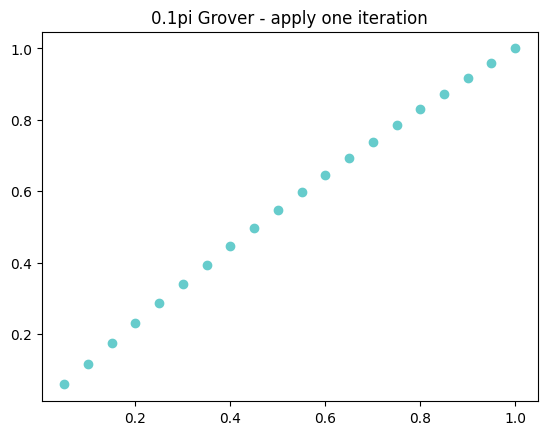

In [132]:
plt.title("0.1pi Grover - apply one iteration")
plt.scatter(x_ot_pi, y_ot_pi, color="#66CCCC")

In [136]:
# test: best probability
x_ot_best = []
y_ot_best = []
for target_state, p in target_states:
    n = math.floor(p * 1024)

    O = createOneTenthPIOracle(target_state)
    diff = createOneTenthPIDiffuser()
    final_state = H_10 @ initState

    p_best = 0.0
    k_tilde = math.floor( 5 * np.sqrt(1024) )
    for i in range(k_tilde):
        final_state = diff @ O @ final_state

        probability = 0.0
        for i in range(1024):
            if i < n:
                probability = probability + measure(measurements[i], final_state)
                
        p_best = max(p_best, probability)
    
#     print(f'p={p}, probability={probability}')
    x_ot_best.append(p)
    y_ot_best.append(p_best)

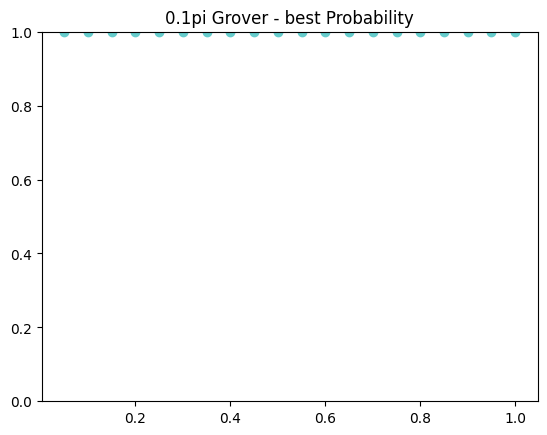

In [174]:
plt.title("0.1pi Grover - best Probability")
plt.ylim(0, 1)
plt.scatter(x_ot_best, y_ot_best, color="#66CCCC")

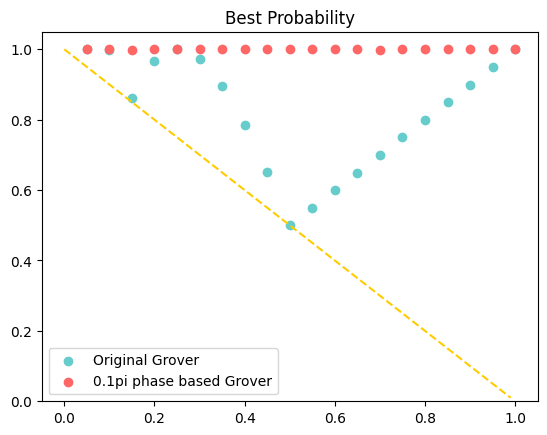

In [272]:
# best probability - 0.1pi vs origin

fig, ax = plt.subplots()
plt.title("Best Probability")
x = np.arange(-0,1,0.01)
y = 1 - x
plt.plot(x, y, ls='--', color="#FFCC00")

plt.ylim(0, 1.05)
plt.scatter(x_o_best, y_o_best, color="#66CCCC", label="Original Grover")
plt.scatter(x_ot_best, y_ot_best, color="#FF6666", label="0.1pi phase based Grover")
ax.legend()

### - 5.3.3 measurements using Youne

In [393]:
# test: best probability
x_y_best = []
y_y_best = []
for _, p in target_states:
    n = math.floor(p * 512)

    O = createYouneOracle(n)
    diff = createYouneDiffuser()
    final_state = Kron( np.eye(2), H_9) @ initState
    
    p_best = 0.0
    k_tilde = math.floor(np.pi / (2 * np.sqrt(2)) * np.sqrt(512 / n))
    for i in range(k_tilde):
        final_state = diff @ O @ final_state
        
    probability = 0.0
    for i in range(512):
        if i < n:
            probability = probability + measure(measurements[i], final_state) + measure(measurements[i + 512], final_state)

    #     print(f'p={p}, probability={probability}')
    x_y_best.append(p)
    y_y_best.append(probability)

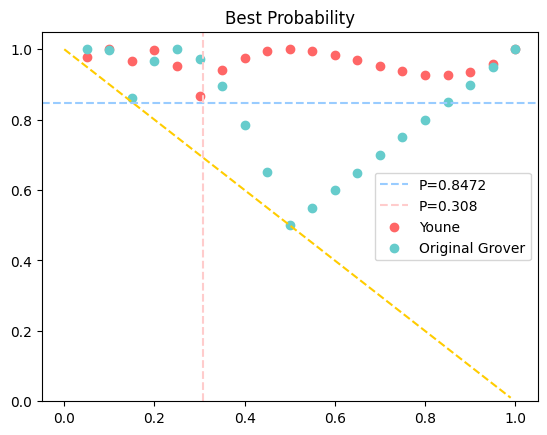

In [408]:
fig, ax = plt.subplots()
plt.title("Best Probability")

x = np.arange(-0, 1, 0.01)
y = 1 - x
plt.plot(x, y, ls='--', color="#FFCC00")

plt.axhline(0.8472, linestyle='--', color="#99CCFF", label="P=0.8472")
plt.axvline(0.308, linestyle='--', color="#FFCCCC", label="P=0.308")

plt.ylim(0, 1.05)
plt.scatter(x_y_best, y_y_best, color="#FF6666", label="Youne")
plt.scatter(x_o_best, y_o_best, color="#66CCCC", label="Original Grover")
ax.legend()

## 6. youne Algorithm

### 6.1 set up starting state

In [176]:
def createYouneInitCircuit():
    circuit = QuantumCircuit(3, 2)
    
    circuit.h(0)
    circuit.h(1)
    circuit.barrier()
    
    return circuit

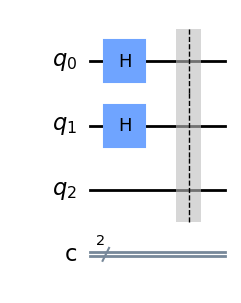

In [177]:
youneInitCircuit = createYouneInitCircuit()
youneInitCircuit.draw(output='mpl')

### 6.2 create youne oracle

In [178]:
def createYouneOracle():
    circuit = QuantumCircuit(3, 2)
    
    circuit.x(0)
    circuit.x(1)
    circuit.ccx(0, 1, 2)
    circuit.x(0)
    circuit.x(1)
    circuit.barrier()
    
    circuit.x(0)
    circuit.ccx(0, 1, 2)
    circuit.x(0)
    circuit.barrier()
    
    return circuit

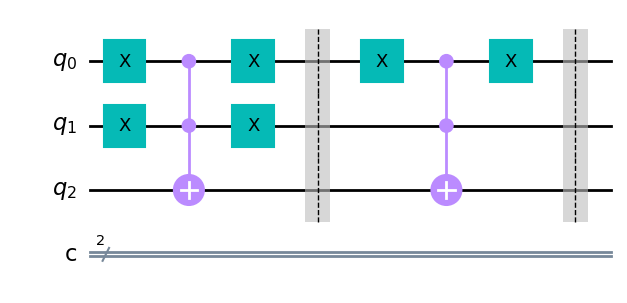

In [179]:
youneOracle = createYouneOracle()
youneOracle.draw(output='mpl')

### 6.3 Diffuser

In [180]:
def createYouneDiffuser():
    circuit = QuantumCircuit(3, 2)
    
    circuit.h(0)
    circuit.h(1)
    circuit.barrier(2)
    
    circuit.x(2)
    circuit.x(0)
    circuit.x(1)
    circuit.h(2)
    circuit.ccx(0, 1, 2)
    circuit.barrier(0)
    circuit.barrier(1)
    circuit.h(2)
    circuit.x(2)
    circuit.x(0)
    circuit.x(1)
    
    circuit.h(0)
    circuit.h(1)
#     circuit.h(2)
    circuit.barrier()
    
    return circuit

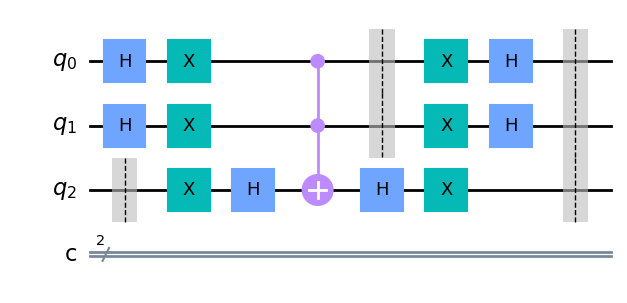

In [181]:
youneDiffuser = createYouneDiffuser()
youneDiffuser.draw(output='mpl')

### 6.4 measurements

In [182]:
youneGroverIteration = createYouneOracle().compose(createYouneDiffuser())

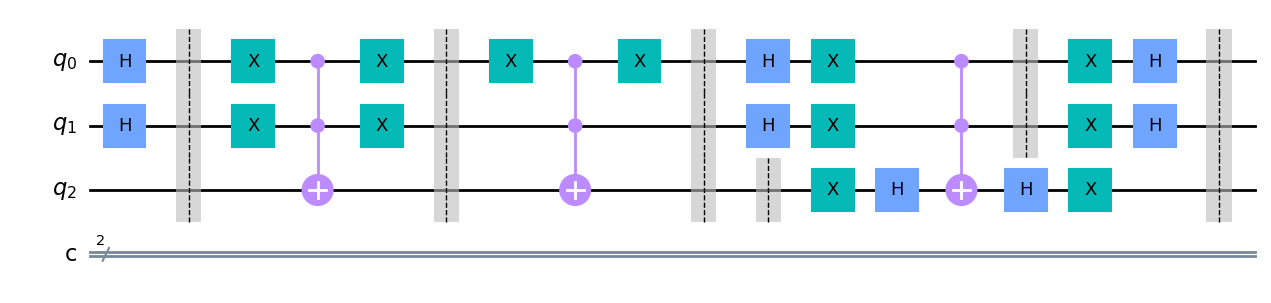

In [183]:
grover_youne = createYouneInitCircuit().compose(youneGroverIteration.copy())
grover_youne.draw(output='mpl')

In [184]:
grover_youne.measure([0, 1], [0, 1])

In [289]:
job = execute(grover_youne, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_youne)
print(counts)

{'10': 4987, '00': 5013}


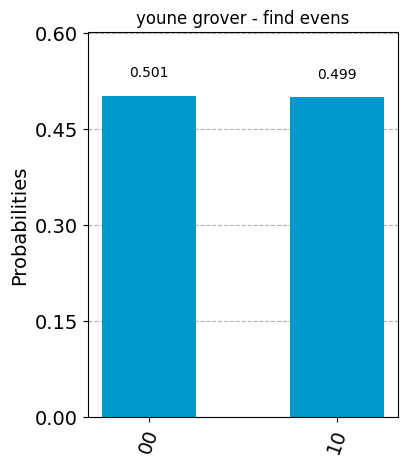

In [290]:
plot_histogram(counts, figsize=(4, 5), color="#0099CC", title="youne grover - find evens")

###  6.5 Another kind of oracle

In [187]:
def createYouneOracle2():
    circuit = QuantumCircuit(3, 2)
    
    circuit.x(0)
    circuit.cx(0, 2)
    circuit.x(0)
    circuit.barrier()
    
    return circuit

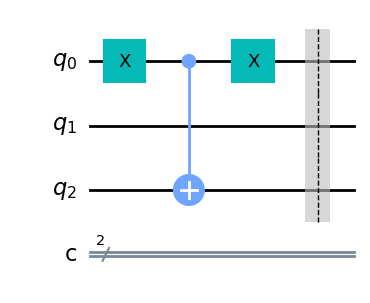

In [188]:
youneOracle2 = createYouneOracle2()
youneOracle2.draw(output='mpl')

In [369]:
# 0 => 4 2 => 6
Operator(youneOracle2).data

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

### 6.6 Measurement using new oracle

In [189]:
youneGroverIteration2 = createYouneOracle2().compose(createYouneDiffuser())

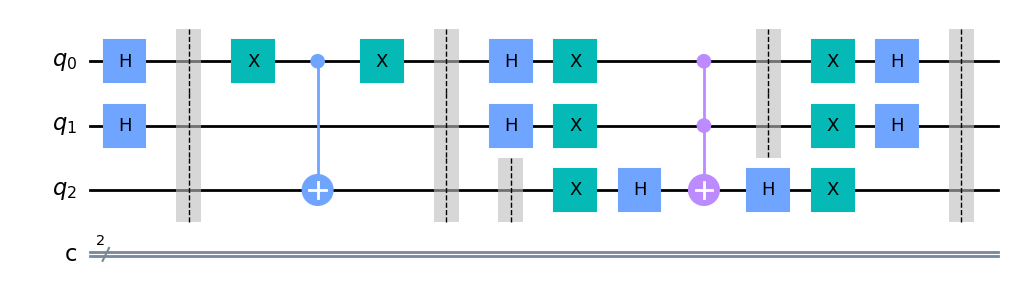

In [190]:
grover_youne2 = createYouneInitCircuit().compose(youneGroverIteration2.copy())
grover_youne2.draw(output='mpl')

In [191]:
grover_youne2.measure([0, 1], [0, 1])

In [192]:
job = execute(grover_youne2, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(grover_youne2)
print(counts)

{'10': 4994, '00': 5006}


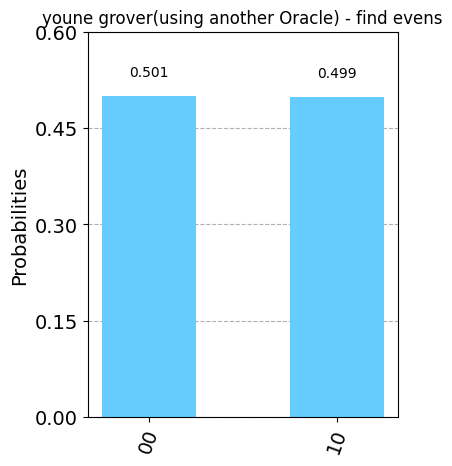

In [193]:
plot_histogram(counts, figsize=(4, 5), color="#66CCFF", title="youne grover(using another Oracle) - find evens")

## 7. SAT

In [194]:
# https://towardsdatascience.com/behind-oracles-grovers-algorithm-amplitude-amplification-46b928b46f1e

### - Example: (a ∧ b ∧ ¬c) ∧ ¬(¬b ∧d ) ∧ ¬d

### 7.1 Generate all the possible assignments for the boolean formula

In [195]:
def createSATInitCircuit(var, clause):
    # input + workspace(clause) + checker(1)
    circuit = QuantumCircuit(var + clause + 1, var)
    
    for i in range(var):
        circuit.h(i)
    circuit.barrier()
    
    return circuit

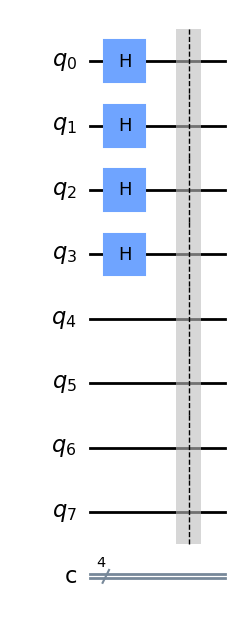

In [196]:
SATInitCircuit = createSATInitCircuit(4, 3)
SATInitCircuit.draw(output='mpl')

### 7.2 Apply Oracle 

In [197]:
def createSATOracle(var, clause):
    circuit = QuantumCircuit(var + clause + 1, var)
    
    # (a ∧ b ∧ ¬c)
    circuit.x(2)
    circuit.mcx([0, 1, 2], 4)
    circuit.x(2)
    circuit.barrier()
    
    # (¬b ∧d )
    circuit.x(1)
    circuit.mcx([1, 3], 5)
    circuit.x(1)
    circuit.barrier()
    
    # ¬d
    circuit.x(3)
    circuit.cx(3, 6)
    circuit.x(3)
    circuit.barrier()
    
    # (a ∧ b ∧ ¬c) ∧ ¬(¬b ∧d ) ∧ ¬d
    circuit.x(5)
    circuit.mcx([4, 5, 6], 7)
    circuit.x(5)
    circuit.barrier()
    
    # uncomputation
    
    # ¬d
    circuit.x(3)
    circuit.cx(3, 6)
    circuit.x(3)
    circuit.barrier()
    
    # (¬b ∧d )
    circuit.x(1)
    circuit.mcx([1, 3], 5)
    circuit.x(1)
    circuit.barrier()
    
    # (a ∧ b ∧ ¬c)
    circuit.x(2)
    circuit.mcx([0, 1, 2], 4)
    circuit.x(2)
    circuit.barrier()
    
    return circuit

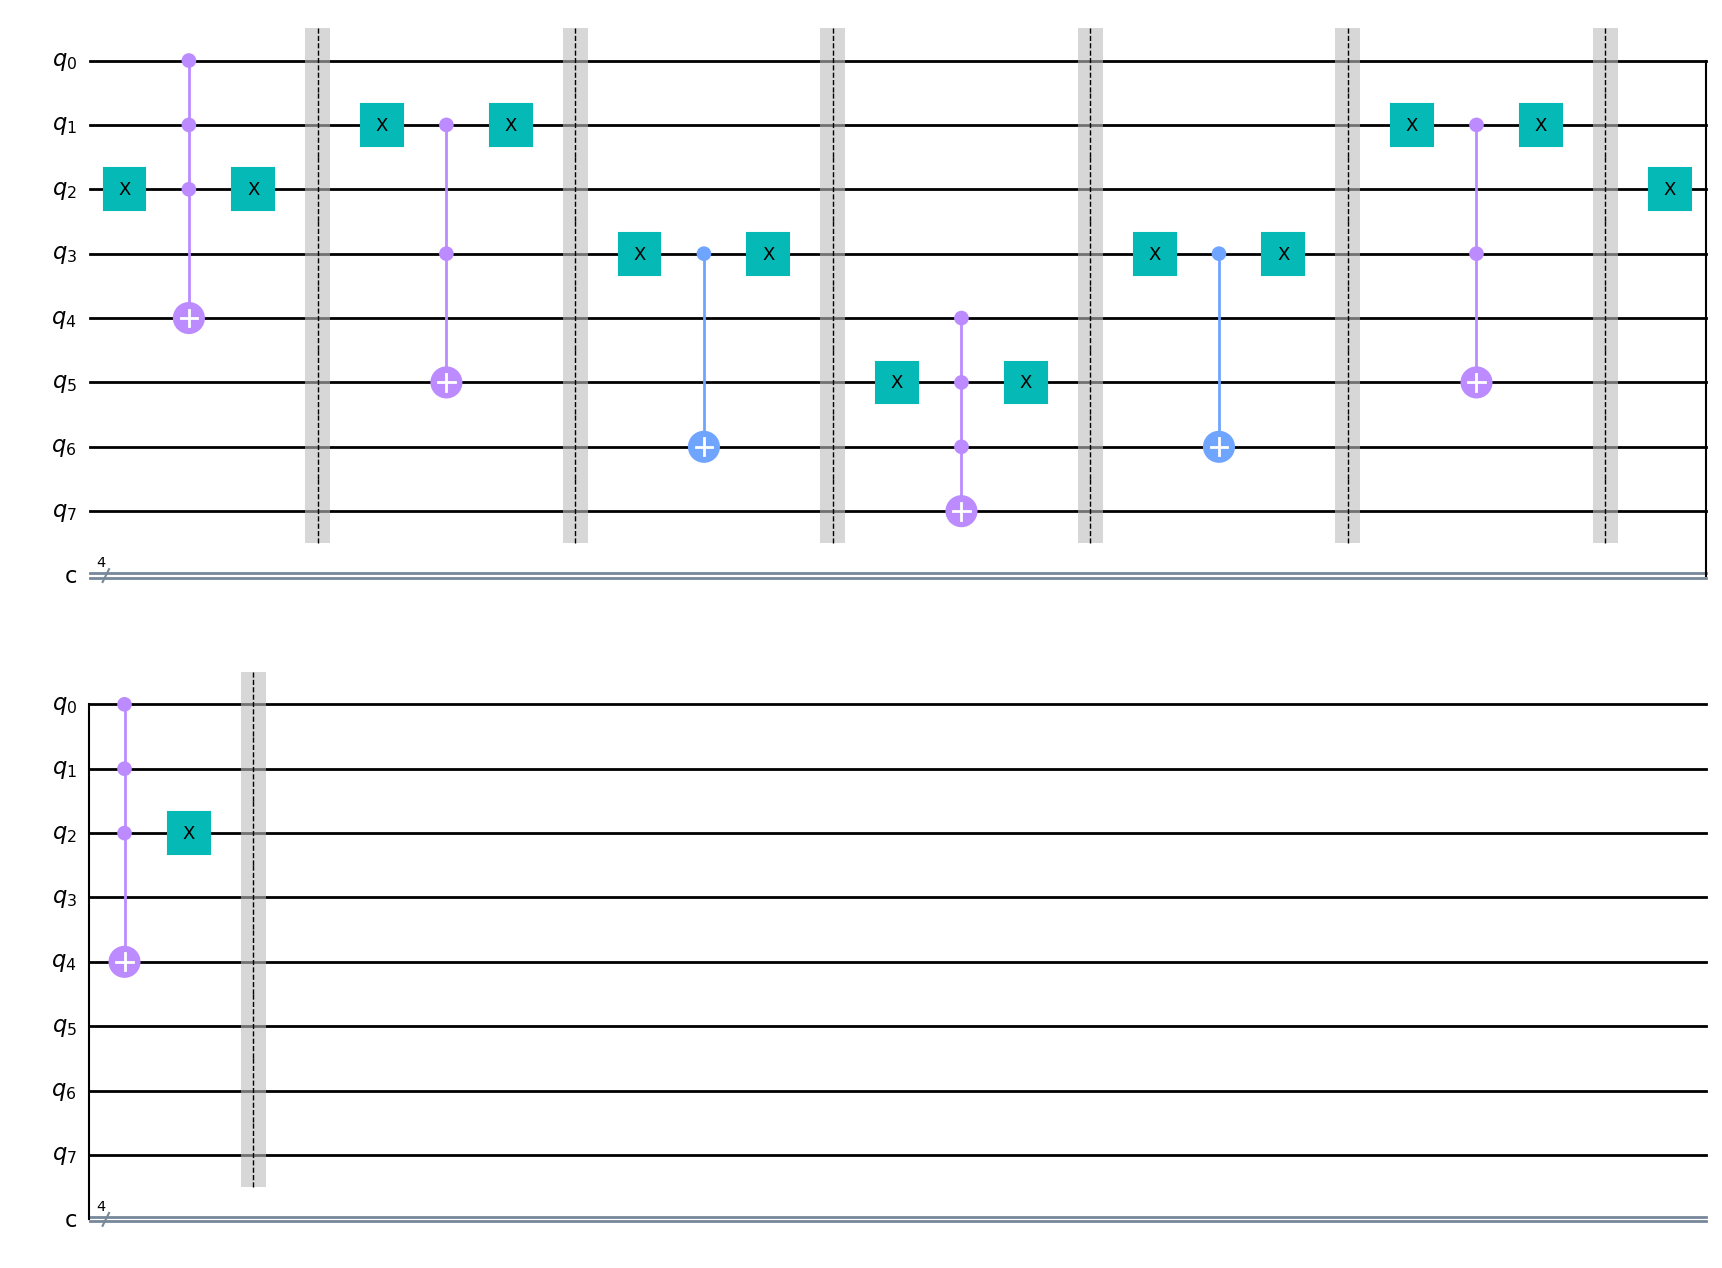

In [291]:
SATOracleCircuit = createSATOracle(4, 3)
SATOracleCircuit.draw(output='mpl')

### 7.3 Apply diffuser

In [200]:
def createSATDiffuser(var, clause):
    circuit = QuantumCircuit(var + clause + 1, var)
    
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.h(3)
    circuit.x(0)
    circuit.x(1)
    circuit.x(2)
    circuit.x(3)
    circuit.mcx([0, 1, 2, 3], var + clause)
    circuit.x(0)
    circuit.x(1)
    circuit.x(2)
    circuit.x(3)
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.h(3)
    
    return circuit

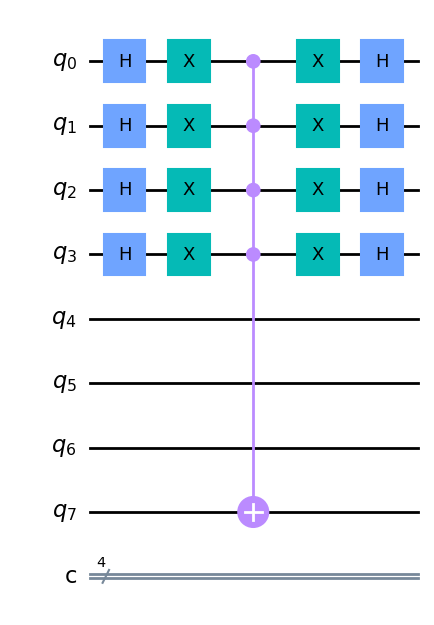

In [201]:
SATDiffuserCircuit = createSATDiffuser(4, 3)
SATDiffuserCircuit.draw(output='mpl')

### 7.4 measurements

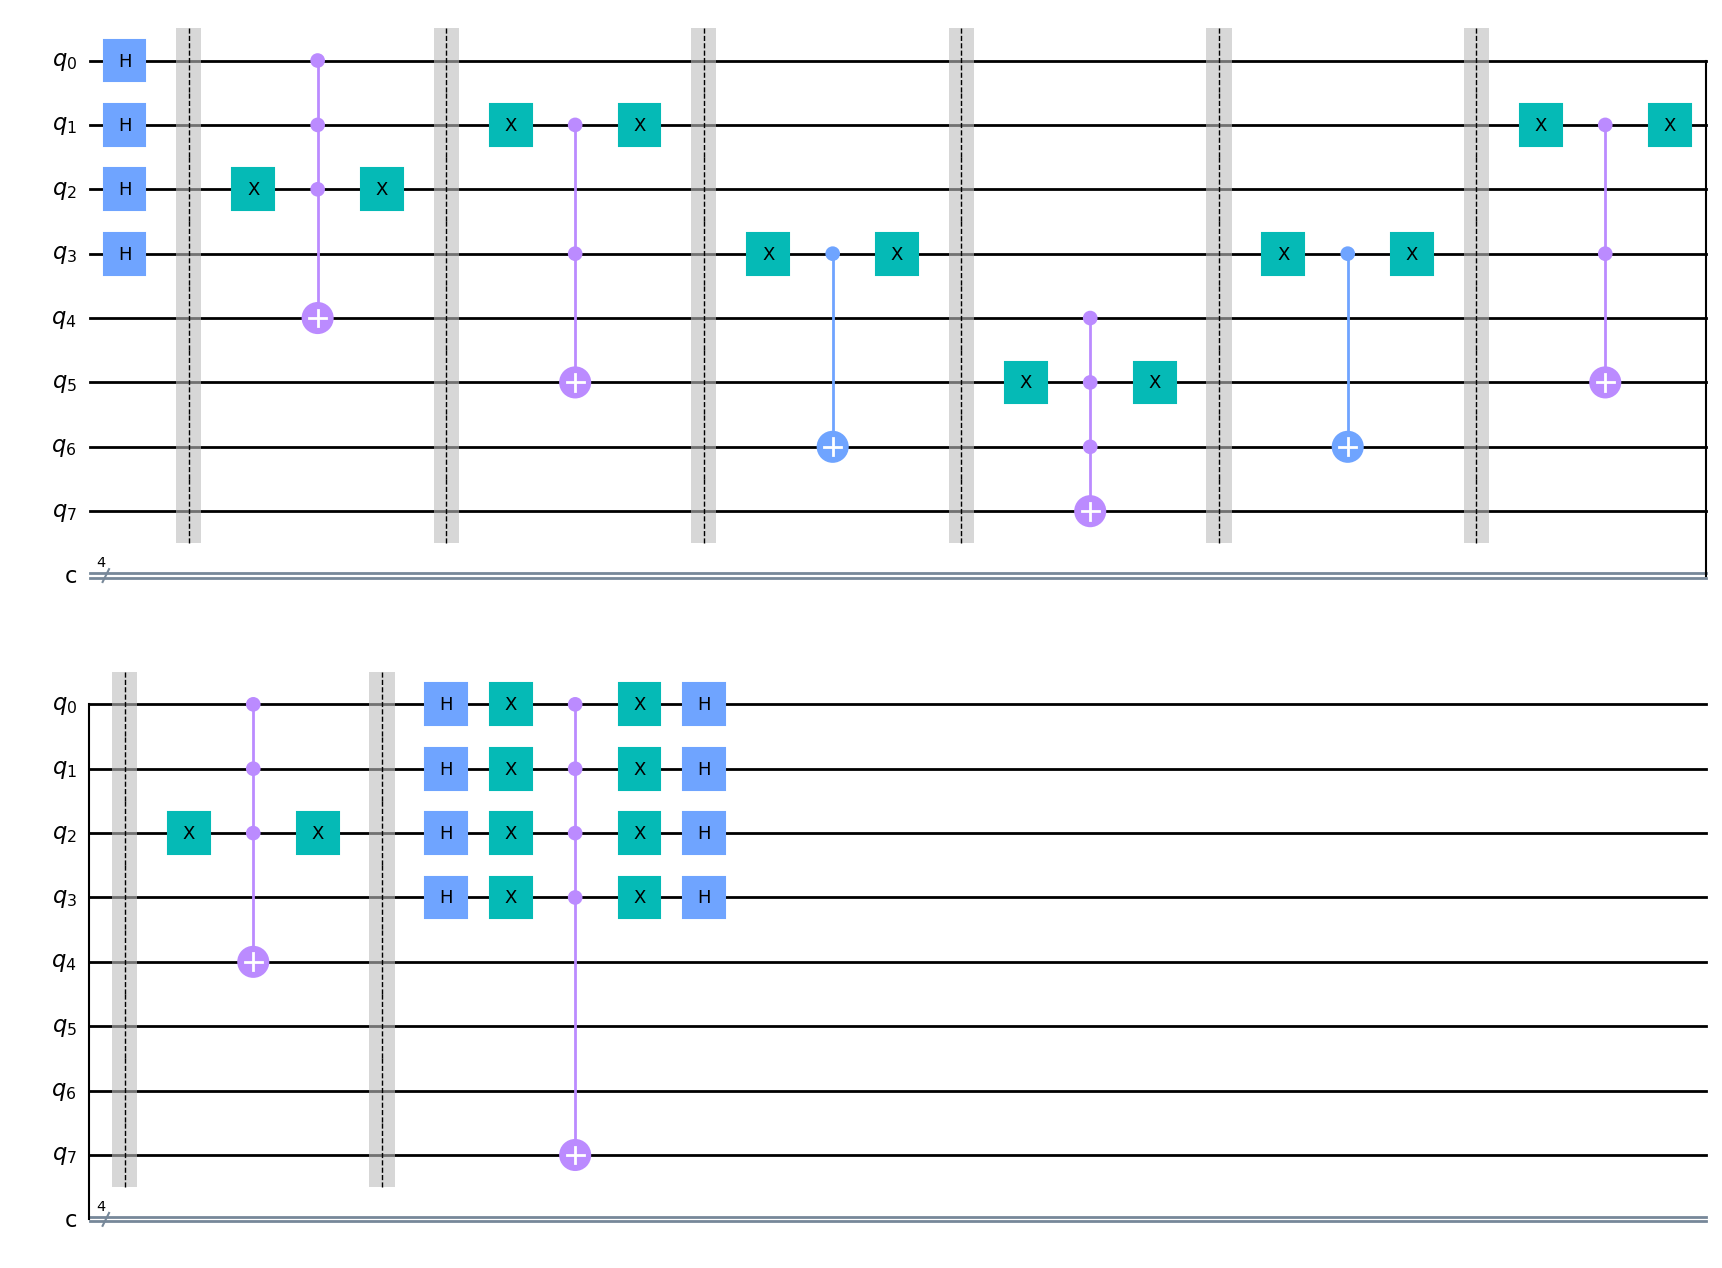

In [202]:
SATCircuit = createSATInitCircuit(4, 3).compose(createSATOracle(4, 3)).compose(createSATDiffuser(4, 3))
SATCircuit.draw(output='mpl')

In [203]:
SATCircuit.measure([0, 1, 2, 3], [0, 1, 2, 3])

In [204]:
job = execute(SATCircuit, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(SATCircuit)
print(counts)

{'0000': 470, '1000': 464, '1011': 507, '0010': 501, '0011': 2710, '1101': 520, '0110': 489, '0101': 458, '1100': 464, '0100': 474, '1010': 528, '1110': 469, '1001': 475, '0111': 512, '0001': 480, '1111': 479}


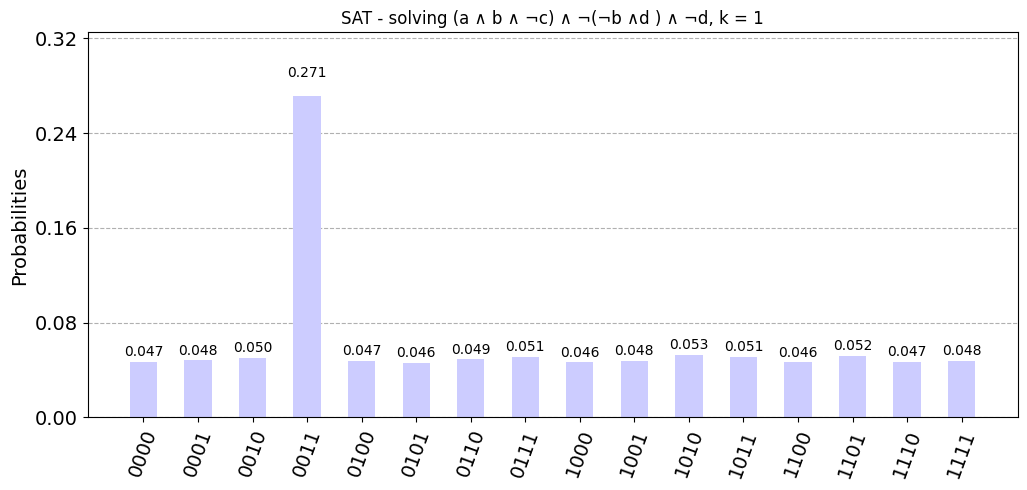

In [205]:
plot_histogram(counts, figsize=(12, 5), color="#CCCCFF", title="SAT - solving (a ∧ b ∧ ¬c) ∧ ¬(¬b ∧d ) ∧ ¬d, k = 1")

### - try several iteration

In [206]:
SATIteration = Operator(createSATOracle(4, 3).compose(createSATDiffuser(4, 3)))

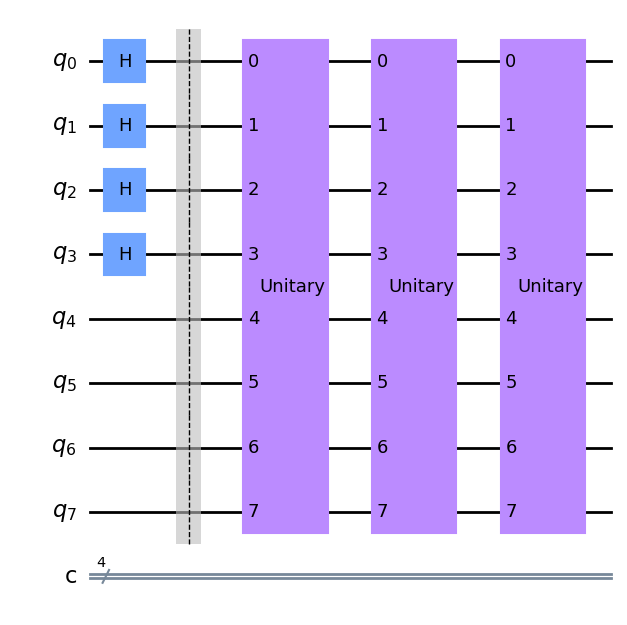

In [207]:
SATCircuit2 = createSATInitCircuit(4, 3)
SATCircuit2.append(SATIteration, list(range(8)))
SATCircuit2.append(SATIteration, list(range(8)))
SATCircuit2.append(SATIteration, list(range(8)))
SATCircuit2.draw(output='mpl')

In [208]:
SATCircuit2.measure([0, 1, 2, 3], [0, 1, 2, 3])

In [209]:
job = execute(SATCircuit2, simulator, shots = 10000)
results = job.result()
counts = results.get_counts(SATCircuit2)
print(counts)

{'1100': 343, '0011': 5040, '0110': 337, '1111': 326, '0111': 320, '0000': 316, '1011': 312, '0010': 345, '1000': 337, '0100': 349, '1110': 296, '0101': 356, '0001': 323, '1001': 324, '1010': 343, '1101': 333}


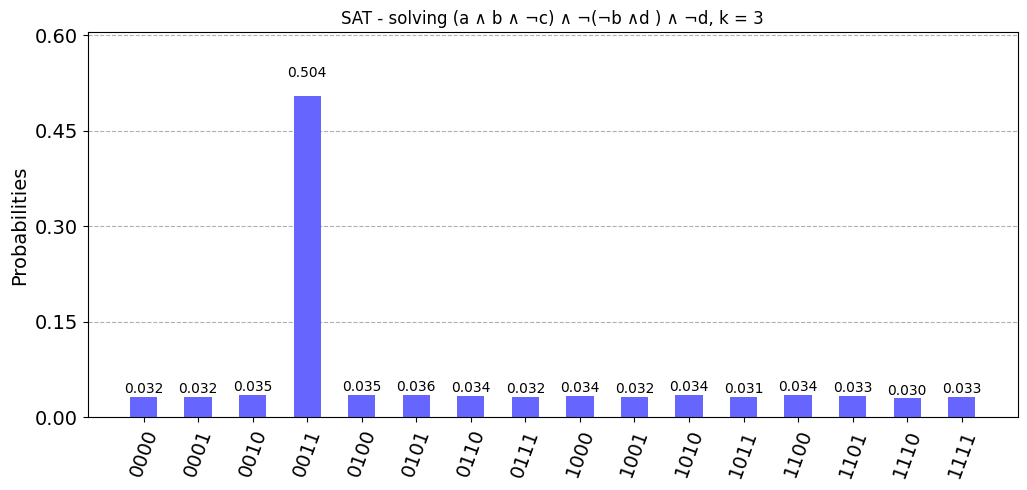

In [210]:
plot_histogram(counts, figsize=(12, 5), color="#6666FF", title="SAT - solving (a ∧ b ∧ ¬c) ∧ ¬(¬b ∧d ) ∧ ¬d, k = 3")

### - theorical calculation

In [211]:
import math

math.degrees( math.asin(1 / 4))

14.477512185929925

In [212]:
for k in range(1, 5):
    print(f'k = {k}: { math.sin(math.radians( (2 * k+1) * 14.47) ) ** 2 }')

k = 1: 0.4722635099875105
k = 2: 0.9080687950400803
k = 3: 0.9616721526193414
k = 4: 0.5828680614140597


## 8. tight bound on iteration times when unknown t/N

In [213]:
# https://arxiv.org/pdf/quant-ph/9605034.pdf

## 8.1 set up starting states

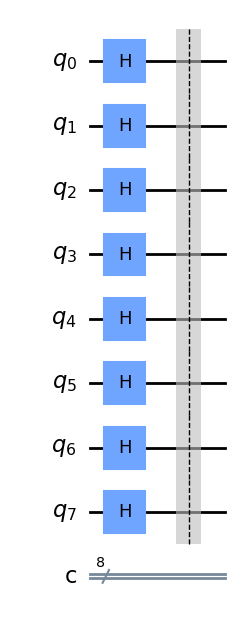

In [214]:
inputCircuit_8q = initCircuit(8)
inputCircuit_8q.draw(output='mpl')

## 8.2 create Oracle

In [215]:
def createOracle_255():
    circuit = QuantumCircuit(8, 8)
    
    circuit.h(7)
    circuit.mcx(list(range(7)), 7)
    circuit.h(7)
    circuit.barrier()
    
    return circuit

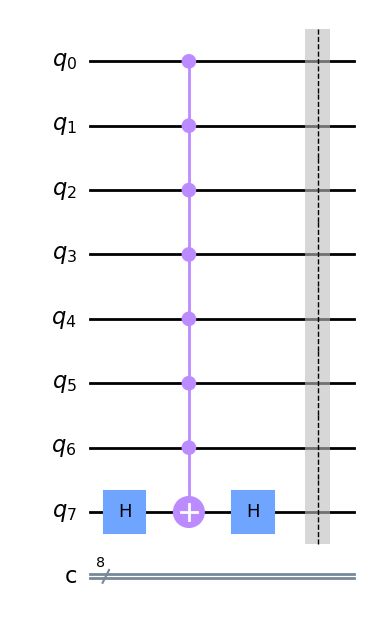

In [216]:
oracleCircuit_255 = createOracle_255()
oracleCircuit_255.draw(output='mpl')

### - test Oracle

In [217]:
Operator(oracleCircuit_255).data

array([[ 1.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        ...,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
         0.+0.00000000e+00j],
       [ 0.+0.00000000e+00j,  1.+0.00000000e+00j,  0.+0.00000000e+00j,
        ...,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
         0.+0.00000000e+00j],
       [ 0.+0.00000000e+00j,  0.+0.00000000e+00j,  1.+0.00000000e+00j,
        ...,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
         0.+0.00000000e+00j],
       ...,
       [ 0.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        ...,  1.-9.71445147e-17j,  0.+0.00000000e+00j,
         0.+0.00000000e+00j],
       [ 0.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        ...,  0.+0.00000000e+00j,  1.+0.00000000e+00j,
         0.+0.00000000e+00j],
       [ 0.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        ...,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        -1.-1.11022302e-16j]])

In [218]:
for index, row in enumerate(Operator(oracleCircuit_255).data):
    if abs(row[index] - -1) < 1e-6:
        print(index)

255


## 8.3 create diffuser

In [219]:
def createR_8q():
    circuit = QuantumCircuit(8, 8)
    
    circuit.x(7)
    circuit.x(6)
    circuit.x(5)
    circuit.x(4)
    circuit.x(3)
    circuit.x(2)
    circuit.x(0)
    circuit.x(1)
    circuit.h(7)
    circuit.mcx(list(range(7)), 7)
    circuit.barrier(0)
    circuit.barrier(1)
    circuit.barrier(2)
    circuit.barrier(3)
    circuit.barrier(4)
    circuit.barrier(5)
    circuit.barrier(6)
    circuit.h(7)
    circuit.x(2)
    circuit.x(0)
    circuit.x(1)
    circuit.x(5)
    circuit.x(4)
    circuit.x(3)
    circuit.x(7)
    circuit.x(6)
    
    return circuit

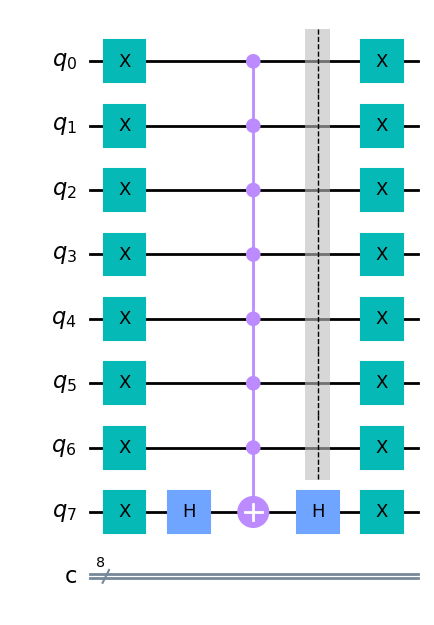

In [220]:
R_8q = createR_8q()
R_8q.draw(output='mpl')

In [221]:
def createDiffuser_8q():
    circuit = QuantumCircuit(8, 8)
    
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.h(3)
    circuit.h(4)
    circuit.h(5)
    circuit.h(6)
    circuit.h(7)
    circuit = circuit.compose(createR_8q())
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.h(3)
    circuit.h(4)
    circuit.h(5)
    circuit.h(6)
    circuit.h(7)
    circuit.barrier()
    
    return circuit

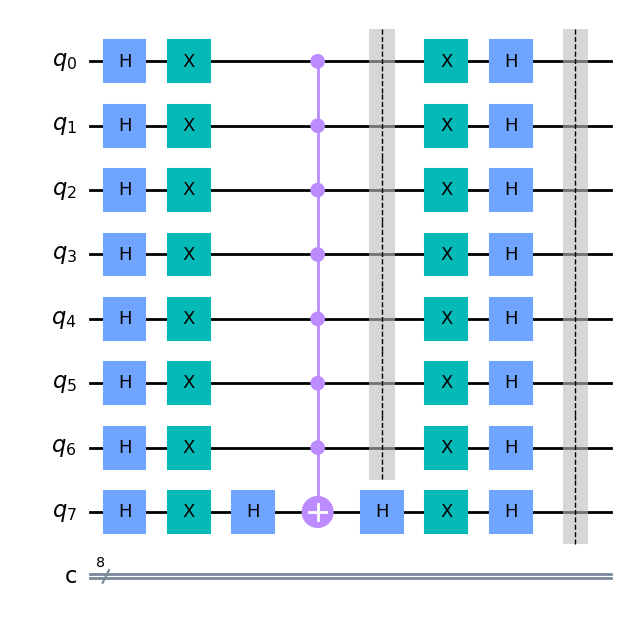

In [222]:
diffuserCircuit_8q = createDiffuser_8q()
diffuserCircuit_8q.draw(output='mpl')

## 8.4 Grover iteration

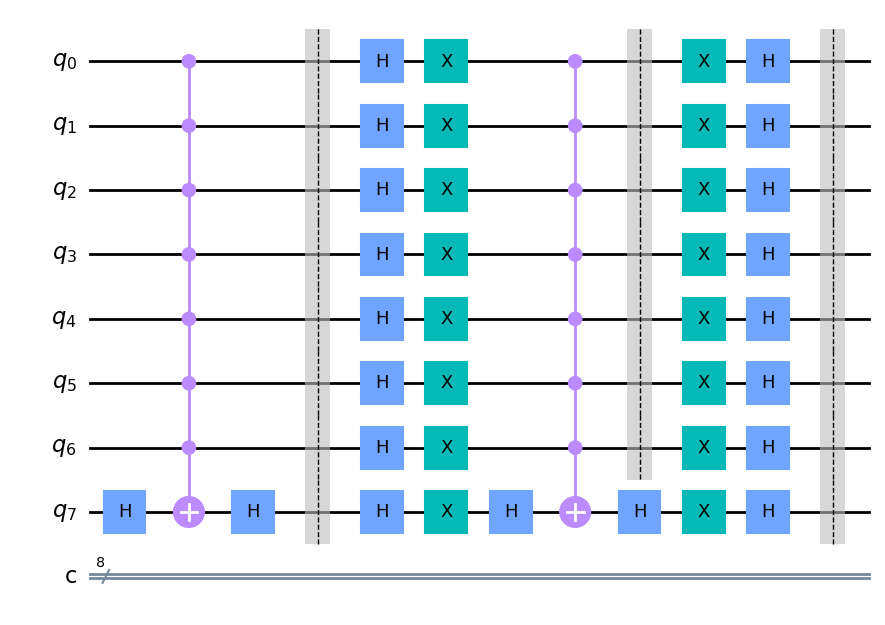

In [223]:
groverIteration_8q = createGroverIteration(createOracle_255(), createDiffuser_8q())
groverIteration_8q.draw(output='mpl')

## 8.5 measurements

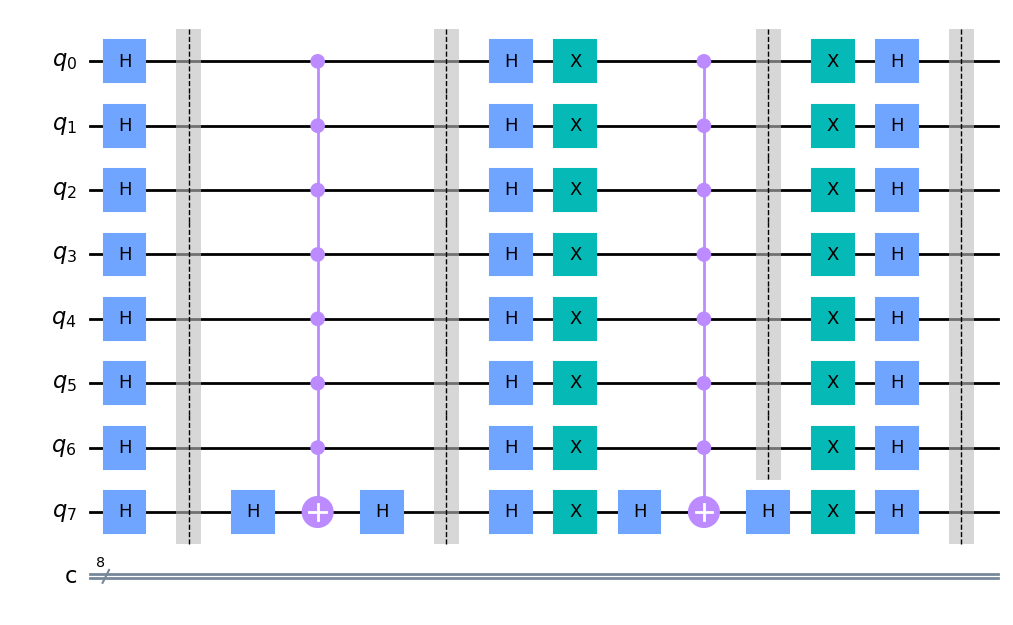

In [224]:
fullCircuit_8q = initCircuit(8).compose(groverIteration_8q)
fullCircuit_8q.draw(output='mpl')

### - theoretical calculation

In [225]:
degree = math.degrees( math.asin(1 / np.sqrt(256)) )
degree

3.583321698471973

In [226]:
for k in range(1, 15):
    print(f'k = {k}: { math.sin(math.radians( (2 * k+1) * degree) ) ** 2 }')

k = 1: 0.0347909927368164
k = 2: 0.0946377220097929
k = 3: 0.17972062825725743
k = 4: 0.28474280203265145
k = 5: 0.4031659976541573
k = 6: 0.5276176773084243
k = 7: 0.650349994727914
k = 8: 0.7637221440185906
k = 9: 0.8606760445971724
k = 10: 0.9351757480633812
k = 11: 0.982583211354746
k = 12: 0.9999470421032736
k = 13: 0.9861862401036727
k = 14: 0.9421574959101175


### - measurement

In [227]:
def groverMeasurements(k):
    circuit = initCircuit(8)
    
    for i in range(k):
        circuit = circuit.compose(groverIteration_8q.copy())
    
    circuit.measure(list(range(8)), list(range(8)))
    
    job = execute(circuit, simulator, shots = 1)
    results = job.result()
    counts = results.get_counts(circuit)
    
    return list(counts)[0]

### - solutions finding algorithm

In [228]:
from random import randrange

def solutionFinding(limit):
    m = 1
    lam = 6 / 5
    count = 0 # iteration times
    
    while count <= limit * (9/4):
        if m > 1:
            j = randrange(0, math.floor(m))
            if j != 0:
                count += j
                answer = groverMeasurements(j)

                if answer == '11111111':
#                     print(f'Find! - total times: {count}')
                    return count, True
        m = min(lam * m, limit)
        
#     print(f'Not find! - total times: {count}')
    return count, False

In [415]:
times = 0
best = 1000
worst = 0
success = 0
for i in range(1000):
    time, flag = solutionFinding(np.sqrt(256)) # √N
    times += time
    best = min(best, time)
    worst = max(worst, time)
    if flag:
        success += 1
print(f'total test times: {1000}')
print('--------------------------')
print(f'Average run times: {times / 1000}')
print(f'best run times: {best}')
print(f'worst run times: {worst}')
print(f'Success rate: {success / 1000 * 100:.2f}%')

total test times: 1000
--------------------------
Average run times: 14.919
best run times: 1
worst run times: 47
Success rate: 99.40%
